In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
# Target 0 = Malignant, 1 = Benign

In [14]:
import os

# 1. This creates the 'data' folder in the Colab environment
# Note: In Colab, we just use 'data' instead of '../data' because of how the file system looks
os.makedirs('data', exist_ok=True)

# 2. This saves your dataframe as a CSV file into that folder
df.to_csv('data/breast_cancer_data.csv', index=False)

print("Dataset saved to 'data/breast_cancer_data.csv' successfully!")

Dataset saved to 'data/breast_cancer_data.csv' successfully!


In [3]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [4]:
# 1. Handling Missing Values (Standard requirement)
df = df.dropna()

# 2. Scaling (Essential for Neural Networks)
scaler = StandardScaler()

# Split before scaling to avoid 'Data Leakage'
# (60% Train, 20% Val, 20% Test)
X = df.drop('target', axis=1)
y = df['target']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# Fit scaler ONLY on training data, then transform all
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/tmp/ipython-input-4093480827.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='viridis')


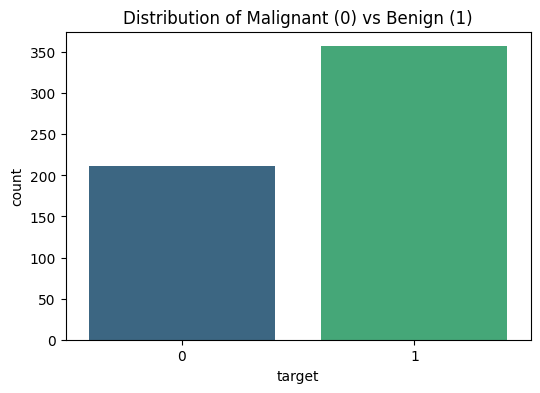

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Distribution of Malignant (0) vs Benign (1)')
plt.show()

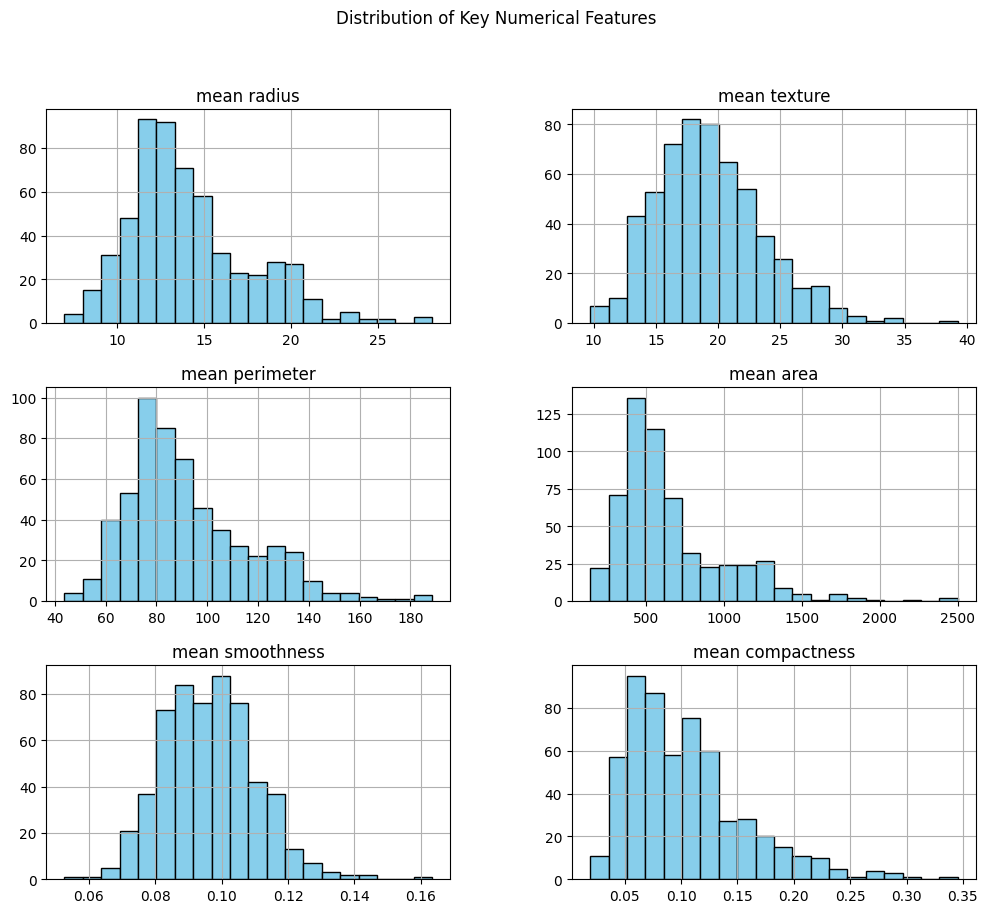

In [6]:
# Plotting distributions of the first 6 features
features_to_plot = df.columns[:6]
df[features_to_plot].hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Key Numerical Features')
plt.show()

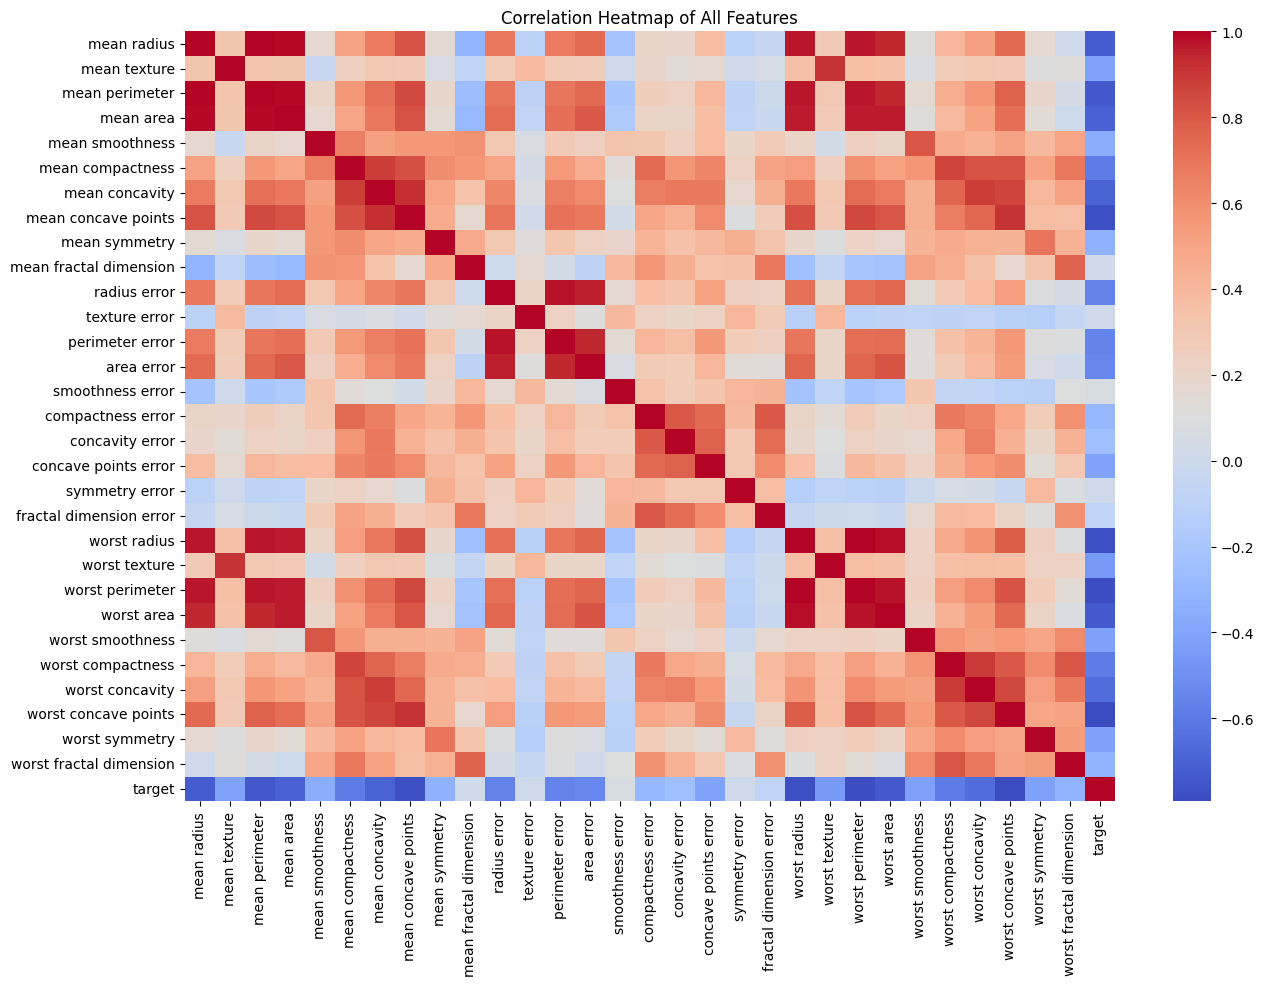

Top correlations with target:
 target                    1.000000
smoothness error          0.067016
mean fractal dimension    0.012838
texture error             0.008303
symmetry error            0.006522
Name: target, dtype: float64


In [7]:
plt.figure(figsize=(15, 10))
# Calculate correlation
corr_matrix = df.corr()
# Plot heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of All Features')
plt.show()

# Highlighting top correlations with the target
target_corr = corr_matrix['target'].sort_values(ascending=False)
print("Top correlations with target:\n", target_corr.head(5))

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Define the architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)), # Dynamic input shape based on features
    Dense(32, activation='relu'),      # Hidden Layer 1
    Dense(16, activation='relu'),      # Hidden Layer 2
    Dense(8, activation='relu'),       # Hidden Layer 3
    Dense(1, activation='sigmoid')     # Output Layer for binary classification
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_auc_score

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement Callbacks (Mandatory for full marks)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/100
 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4731 - loss: 0.7172

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.5186 - loss: 0.7096 - val_accuracy: 0.6842 - val_loss: 0.6758
Epoch 2/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6875 - loss: 0.6890

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7712 - loss: 0.6601 - val_accuracy: 0.8070 - val_loss: 0.6315
Epoch 3/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7812 - loss: 0.6215

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8185 - loss: 0.6112 - val_accuracy: 0.8509 - val_loss: 0.5741
Epoch 4/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8750 - loss: 0.5473

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8727 - loss: 0.5434 - val_accuracy: 0.8684 - val_loss: 0.4995
Epoch 5/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8890 - loss: 0.4901 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8973 - loss: 0.4769 - val_accuracy: 0.8684 - val_loss: 0.4123
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9184 - loss: 0.3827 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9183 - loss: 0.3789 - val_accuracy: 0.8860 - val_loss: 0.3276
Epoch 7/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - accuracy: 0.8750 - loss: 0.3500

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9201 - loss: 0.2966 - val_accuracy: 0.8947 - val_loss: 0.2659
Epoch 8/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9375 - loss: 0.2367

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9399 - loss: 0.2233 - val_accuracy: 0.9298 - val_loss: 0.2230
Epoch 9/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.1319

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9398 - loss: 0.1943 - val_accuracy: 0.9298 - val_loss: 0.1904
Epoch 10/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9375 - loss: 0.1736

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9323 - loss: 0.1672 - val_accuracy: 0.9561 - val_loss: 0.1662
Epoch 11/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0816

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9677 - loss: 0.1180 - val_accuracy: 0.9561 - val_loss: 0.1487
Epoch 12/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9688 - loss: 0.1166

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9690 - loss: 0.1080 - val_accuracy: 0.9561 - val_loss: 0.1349
Epoch 13/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9375 - loss: 0.1184

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9597 - loss: 0.1125 - val_accuracy: 0.9561 - val_loss: 0.1228
Epoch 14/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9375 - loss: 0.0904

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9740 - loss: 0.0751 - val_accuracy: 0.9561 - val_loss: 0.1142
Epoch 15/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9688 - loss: 0.1315

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9732 - loss: 0.0973 - val_accuracy: 0.9737 - val_loss: 0.1052
Epoch 16/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 1.0000 - loss: 0.0541

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9854 - loss: 0.0835 - val_accuracy: 0.9825 - val_loss: 0.0984
Epoch 17/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9688 - loss: 0.1350

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9800 - loss: 0.0848 - val_accuracy: 0.9737 - val_loss: 0.0939
Epoch 18/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0705

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9909 - loss: 0.0579 - val_accuracy: 0.9737 - val_loss: 0.0898
Epoch 19/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0600

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9862 - loss: 0.0588 - val_accuracy: 0.9737 - val_loss: 0.0862
Epoch 20/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9688 - loss: 0.1313

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9796 - loss: 0.0644 - val_accuracy: 0.9737 - val_loss: 0.0835
Epoch 21/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0341

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9946 - loss: 0.0414 - val_accuracy: 0.9737 - val_loss: 0.0817
Epoch 22/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9688 - loss: 0.1149

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9843 - loss: 0.0648 - val_accuracy: 0.9649 - val_loss: 0.0797
Epoch 23/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0140

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9879 - loss: 0.0408 - val_accuracy: 0.9649 - val_loss: 0.0782
Epoch 24/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9688 - loss: 0.0873

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9888 - loss: 0.0440 - val_accuracy: 0.9649 - val_loss: 0.0770
Epoch 25/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0440

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9930 - loss: 0.0430 - val_accuracy: 0.9649 - val_loss: 0.0761
Epoch 26/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0273

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9947 - loss: 0.0292 - val_accuracy: 0.9649 - val_loss: 0.0754
Epoch 27/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0141

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9951 - loss: 0.0273 - val_accuracy: 0.9649 - val_loss: 0.0748
Epoch 28/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0193

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9881 - loss: 0.0366 - val_accuracy: 0.9649 - val_loss: 0.0741
Epoch 29/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9688 - loss: 0.0642

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9894 - loss: 0.0347 - val_accuracy: 0.9649 - val_loss: 0.0731
Epoch 30/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0155

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9960 - loss: 0.0210 - val_accuracy: 0.9649 - val_loss: 0.0724
Epoch 31/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0153

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9933 - loss: 0.0254 - val_accuracy: 0.9649 - val_loss: 0.0720
Epoch 32/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0069

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9931 - loss: 0.0200 - val_accuracy: 0.9737 - val_loss: 0.0715
Epoch 33/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0143

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9922 - loss: 0.0241 - val_accuracy: 0.9737 - val_loss: 0.0706
Epoch 34/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9688 - loss: 0.0486

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9892 - loss: 0.0260 - val_accuracy: 0.9825 - val_loss: 0.0698
Epoch 35/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9688 - loss: 0.0514

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9884 - loss: 0.0264 - val_accuracy: 0.9825 - val_loss: 0.0691
Epoch 36/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0222

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9960 - loss: 0.0160 - val_accuracy: 0.9825 - val_loss: 0.0685
Epoch 37/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9688 - loss: 0.0387

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9883 - loss: 0.0215 - val_accuracy: 0.9825 - val_loss: 0.0680
Epoch 38/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0014

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9874 - loss: 0.0208 - val_accuracy: 0.9825 - val_loss: 0.0672
Epoch 39/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0146

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9958 - loss: 0.0138 - val_accuracy: 0.9912 - val_loss: 0.0670
Epoch 40/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9688 - loss: 0.0260

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9842 - loss: 0.0188 - val_accuracy: 0.9912 - val_loss: 0.0668
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9901 - loss: 0.0186 - val_accuracy: 0.9912 - val_loss: 0.0670
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9919 - loss: 0.0207 - val_accuracy: 0.9912 - val_loss: 0.0671
Epoch 43/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9945 - loss: 0.0136 - val_accuracy: 0.9912 - val_loss: 0.0668
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9967 - loss: 0.0113 - val_accuracy: 0.9912 - val_loss: 0.0669
Epoch 45/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9983 - loss: 0.0097 - val_accuracy: 0.9912 - val_loss: 0.0672
Epoch 46/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0062

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9978 - loss: 0.0123 - val_accuracy: 0.9912 - val_loss: 0.0666
Epoch 47/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9978 - loss: 0.0086 - val_accuracy: 0.9912 - val_loss: 0.0668
Epoch 48/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0038

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9912 - val_loss: 0.0664
Epoch 49/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0092

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9912 - val_loss: 0.0662
Epoch 50/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9912 - val_loss: 0.0666
Epoch 51/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.9912 - val_loss: 0.0672
Epoch 52/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.9825 - val_loss: 0.0677
Epoch 53/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.9825 - val_loss: 0.0676
Epoch 54/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9825 - val_loss: 0.0684
Epoch 55/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9825 - val_loss: 0.0686
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9825 - val_

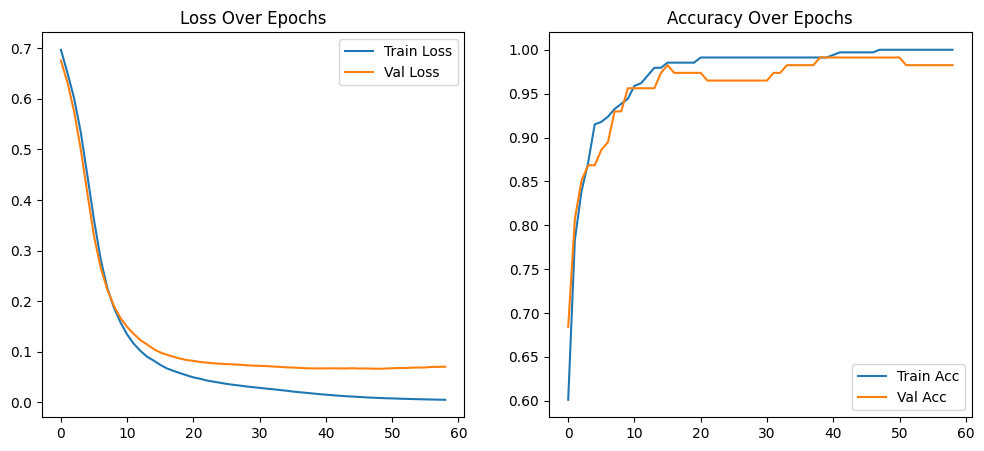

In [10]:
# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [11]:
# Load the best weights saved by checkpoint
model.load_weights('best_model.h5')

# Evaluate on held-out test set
predictions = (model.predict(X_test) > 0.5).astype("int32")
y_prob = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, predictions))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        42
           1       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

ROC-AUC Score: 0.9931


In [13]:
model.save('models/best_model.h5')

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print the report
print(classification_report(y_test, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        42
           1       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

